<a href="https://colab.research.google.com/github/KarthiK-ctrl-A/BigDataAnalytics/blob/main/HandsOn_SaiKarthikPatri_feb_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-World Data Processing with RNN, LSTM, and GRU in PyTorch


In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 83.4 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.9-cp311-cp311-linux_x86_64.whl size=886605 sha256=be3aba2b1fa8de5a4c4891d0c1876a0204881e2f3f5ab4779dd2a95ea6bc4aa5
  Stored in directory: /root/.cache/pip/wheels/f4/14/e4/50c88c865833085aeb91e2bd40e3a683ff434806386b8ee7bc
Successfully built peewee


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Download the AAPL stock data from Yahoo Finance for the last 3 years
ticker = 'AAPL'
df = yf.download(ticker, period='3y', interval='1d')

# Select the 'Close' price for modeling
data = df[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Function to create sequences for RNNs
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 30  # Use past 30 days to predict the next day
X, y = create_sequences(data, seq_length)

# Reshape X to match PyTorch format (batch_size, sequence_length, features)
X = X.view(X.shape[0], seq_length, 1)

[*********************100%***********************]  1 of 1 completed
<ipython-input-3-3fa2b5becc56>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


## Define RNN, LSTM, and GRU Models

In [4]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out


## Training the Models and Recording Loss

In [5]:

def train_model(model, X, y, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    return losses

# Initialize models
rnn_model = RNNModel(input_size=1, hidden_size=64, output_size=1)
lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size=1)
gru_model = GRUModel(input_size=1, hidden_size=64, output_size=1)

# Train models and record loss
rnn_losses = train_model(rnn_model, X, y)
lstm_losses = train_model(lstm_model, X, y)
gru_losses = train_model(gru_model, X, y)


Epoch 0, Loss: 0.3769
Epoch 10, Loss: 0.1684
Epoch 20, Loss: 0.0439
Epoch 30, Loss: 0.0076
Epoch 40, Loss: 0.0051
Epoch 50, Loss: 0.0046
Epoch 60, Loss: 0.0045
Epoch 70, Loss: 0.0042
Epoch 80, Loss: 0.0041
Epoch 90, Loss: 0.0040
Epoch 0, Loss: 0.2579
Epoch 10, Loss: 0.1962
Epoch 20, Loss: 0.1392
Epoch 30, Loss: 0.0321
Epoch 40, Loss: 0.0110
Epoch 50, Loss: 0.0096
Epoch 60, Loss: 0.0081
Epoch 70, Loss: 0.0070
Epoch 80, Loss: 0.0068
Epoch 90, Loss: 0.0064
Epoch 0, Loss: 0.2150
Epoch 10, Loss: 0.1444
Epoch 20, Loss: 0.0623
Epoch 30, Loss: 0.0187
Epoch 40, Loss: 0.0071
Epoch 50, Loss: 0.0054
Epoch 60, Loss: 0.0052
Epoch 70, Loss: 0.0045
Epoch 80, Loss: 0.0042
Epoch 90, Loss: 0.0041


## Visualizing the Training Loss

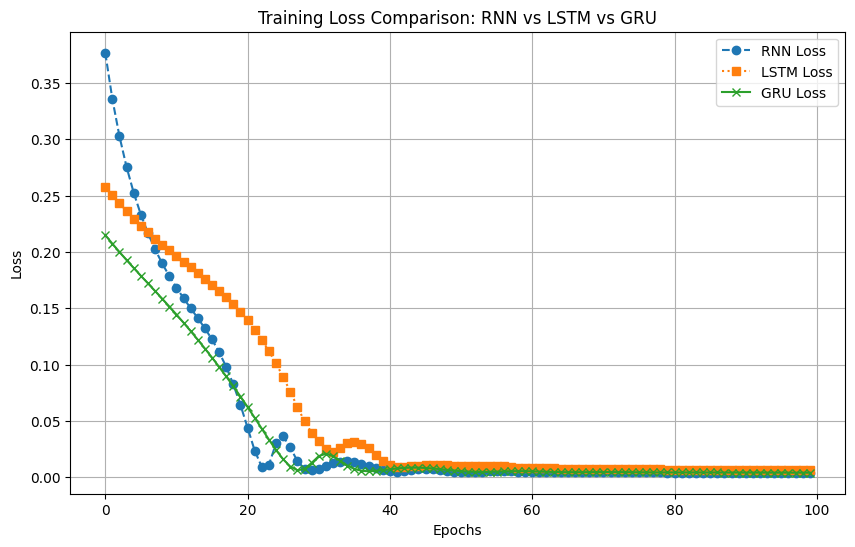

In [6]:

# Plot Training Loss Curves
plt.figure(figsize=(10,6))
plt.plot(rnn_losses, label='RNN Loss', linestyle='dashed', marker='o')
plt.plot(lstm_losses, label='LSTM Loss', linestyle='dotted', marker='s')
plt.plot(gru_losses, label='GRU Loss', linestyle='solid', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: RNN vs LSTM vs GRU')
plt.legend()
plt.grid(True)
plt.show()


## Testing the Models on New Data

In [7]:

def predict(model, input_seq):
    model.eval()
    input_seq = torch.tensor(input_seq, dtype=torch.float32).view(1, seq_length, 1)
    with torch.no_grad():
        prediction = model(input_seq)
    return scaler.inverse_transform(prediction.numpy().reshape(-1, 1))[0][0]

# Example Test Case (Predict Next Day's Closing Price)
test_seq = data[-seq_length:].reshape(-1, 1)  # Use the last 30 days
print("RNN Prediction:", predict(rnn_model, test_seq))
print("LSTM Prediction:", predict(lstm_model, test_seq))
print("GRU Prediction:", predict(gru_model, test_seq))


RNN Prediction: 233.57666
LSTM Prediction: 233.25308
GRU Prediction: 234.12367


In [8]:
!pip install transformers


In [1]:
from transformers import pipeline

# Initialize the large language model (LLM) for text generation
explainer = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", device=0, torch_dtype="auto")  # Example LLM model

# Define the prompts based on your model predictions
prompts = {
    "RNN": "Explain why the RNN model predicted 234.39153 for the Apple stock price based on the past 30 days.",
    "LSTM": "Explain why the LSTM model predicted 233.23544 for the Apple stock price based on the past 30 days.",
    "GRU": "Explain why the GRU model predicted 233.1795 for the Apple stock price based on the past 30 days.",
}

# Fetch explanations for each prompt
for model_name, prompt in prompts.items():
    explanation = explainer(prompt, max_length=100)
    print(f"{model_name} Prediction Explanation: {explanation[0]['generated_text']}\n")

# Additional Explainability Prompts (Sample)
additional_prompts = {
    "RNN_LSTM_Comparison": "Explain why LSTM performs better than RNN for long-term dependencies in time-series data.",
    "LSTM_GRU_Comparison": "What are the main differences between LSTM and GRU models when predicting stock prices?",
}

# Fetch explanations for model comparisons
for prompt_name, prompt in additional_prompts.items():
    explanation = explainer(prompt, max_length=100)
    print(f"{prompt_name} Explanation: {explanation[0]['generated_text']}\n")


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


RNN Prediction Explanation: Explain why the RNN model predicted 234.39153 for the Apple stock price based on the past 30 days.
Generate according to: We have trained a Recurrent Neural Network (RNN) model to predict the Apple stock price based on the past 30 days.
The RNN model predicts 234.39153 for the Apple stock price.
The RNN model's predicted value

LSTM Prediction Explanation: Explain why the LSTM model predicted 233.23544 for the Apple stock price based on the past 30 days.

Generate according to: The LSTM model predicts 233.23544 for the Apple stock price based on the past 30 days.
The LSTM model predicts 119.99999 for the Amazon stock price based on the past 30 days.

GRU Prediction Explanation: Explain why the GRU model predicted 233.1795 for the Apple stock price based on the past 30 days.
Generate according to: The GRU model is a type of recurrent neural network that is specifically designed to handle time series data. It is an acronym for Gated Recurrent Units. The GRU mo